In [43]:
import numpy as np
import pandas as pd
import re
from urllib.parse import urlparse
from textblob import TextBlob
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk import ngrams
import seaborn as sns
from multiprocessing import Pool, cpu_count
from itertools import chain
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA

In [5]:
df = pd.read_csv("IMDB Dataset.csv")
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [6]:
df.shape

(50000, 2)

In [7]:
df["review"][5689]

'Everyone in a while, Disney makes one of thoes movies that surprises everyone. One that keeps you wondering until the very end. In the tradition of Pirates of the Caribbean, this movie is sure to turn into a ghost, and kill and rape your village. It\'s terrible. If you want a mindless, senseless, predictable "action" movie, go right ahead. I believe that young kids might enjoy this, as they like it when Good ALWAYS wins. But me, I like movies where it\'s a toss up who\'s going to win. This movie never lets the Bad Guys have the upper hand. By the end, when th heroes are left in an "inescapeable" pit, you just KNOW that they can get out. Everything works out perfect for Cage and his friends, he never has to think over a riddle or clue for more than 10 seconds, no matter how complex it is. See this movie if you want to see some impressive set designs, not if you want to see good acting, or a good film. Go watch a superman movie, it would be much shorter, and the kids would like it more.

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [9]:
df.duplicated().sum()

418

In [10]:
df = df.drop_duplicates()

In [11]:
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


## Cleaning Dataset


In [12]:
# Lowercase

df['review'] = df['review'].str.lower()
df['review']

0        one of the other reviewers has mentioned that ...
1        a wonderful little production. <br /><br />the...
2        i thought this was a wonderful way to spend ti...
3        basically there's a family where a little boy ...
4        petter mattei's "love in the time of money" is...
                               ...                        
49995    i thought this movie did a down right good job...
49996    bad plot, bad dialogue, bad acting, idiotic di...
49997    i am a catholic taught in parochial elementary...
49998    i'm going to have to disagree with the previou...
49999    no one expects the star trek movies to be high...
Name: review, Length: 49582, dtype: object

In [13]:
# Remove Whitespaces

df['review'] = df['review'].str.strip()
df['review']

0        one of the other reviewers has mentioned that ...
1        a wonderful little production. <br /><br />the...
2        i thought this was a wonderful way to spend ti...
3        basically there's a family where a little boy ...
4        petter mattei's "love in the time of money" is...
                               ...                        
49995    i thought this movie did a down right good job...
49996    bad plot, bad dialogue, bad acting, idiotic di...
49997    i am a catholic taught in parochial elementary...
49998    i'm going to have to disagree with the previou...
49999    no one expects the star trek movies to be high...
Name: review, Length: 49582, dtype: object

In [14]:
# Remove HTML Tag

df['review'] = df['review'].str.replace(r'<.*?>','', regex=True)
df['review']

0        one of the other reviewers has mentioned that ...
1        a wonderful little production. the filming tec...
2        i thought this was a wonderful way to spend ti...
3        basically there's a family where a little boy ...
4        petter mattei's "love in the time of money" is...
                               ...                        
49995    i thought this movie did a down right good job...
49996    bad plot, bad dialogue, bad acting, idiotic di...
49997    i am a catholic taught in parochial elementary...
49998    i'm going to have to disagree with the previou...
49999    no one expects the star trek movies to be high...
Name: review, Length: 49582, dtype: object

In [15]:
# Code to Remove URL

df['review'] = df['review'].str.replace(r"https?://\S+|www\.\S+",'', regex=True)
df['review']

0        one of the other reviewers has mentioned that ...
1        a wonderful little production. the filming tec...
2        i thought this was a wonderful way to spend ti...
3        basically there's a family where a little boy ...
4        petter mattei's "love in the time of money" is...
                               ...                        
49995    i thought this movie did a down right good job...
49996    bad plot, bad dialogue, bad acting, idiotic di...
49997    i am a catholic taught in parochial elementary...
49998    i'm going to have to disagree with the previou...
49999    no one expects the star trek movies to be high...
Name: review, Length: 49582, dtype: object

In [16]:
# Code to check if a review contains an URL

df[df['review'].str.contains(r"https?://\S+|www\.\S+",'', regex=True)]

,review,sentiment


In [17]:
# Expanding Abbreviations

def remove_abb(text):

    if not isinstance(text, str) or not text.strip():
        return text
    
    # Unified replacement mapping (add new entries here)
    replacements = {
        # Standard contractions
        r"won't": "will not",
        r"can't": "cannot",
        r"n't": " not",
        r"'re": " are",
        r"'s": " is",
        r"'d": " would",
        r"'ll": " will",
        r"'ve": " have",
        r"'m": " am",
        
        # Special cases and Unicode artifacts
        r"\bhe's\b": "he is",
        r"\bdon\x89Ûªt\b": "do not",
        r"\bDon\x89Ûªt\b": "Do not",
        r"\byou\x89Ûªre\b": "you are",
        r"\bi\x89Ûªm\b": "I am",
        r"\by'all\b": "you all",
        r"\bY'all\b": "You all",
        r"\bain't\b": "am not",
        
        # Mixed case handling (add more as needed)
        r"(?i)\bwhat's\b": "what is",
        r"(?i)\bit's\b": "it is",
        r"(?i)\bthat's\b": "that is",
        r"(?i)\bhere's\b": "here is",
        r"(?i)\bthere's\b": "there is"
    }
    
    # Apply all replacements
    for pattern, replacement in replacements.items():
        text = re.sub(pattern, replacement, text)
    
    # Post-processing fixes
    text = re.sub(r"\bI am\b", "I am", text)
    text = re.sub(r"\bi am\b", "I am", text)
    text = re.sub(r"\b(cannot)\b", "can not", text)
    
    return text

In [18]:
df['review'] = df['review'].apply(remove_abb)
df['review']

0        one of the other reviewers has mentioned that ...
1        a wonderful little production. the filming tec...
2        i thought this was a wonderful way to spend ti...
3        basically there is a family where a little boy...
4        petter mattei is "love in the time of money" i...
                               ...                        
49995    i thought this movie did a down right good job...
49996    bad plot, bad dialogue, bad acting, idiotic di...
49997    I am a catholic taught in parochial elementary...
49998    I am going to have to disagree with the previo...
49999    no one expects the star trek movies to be high...
Name: review, Length: 49582, dtype: object

In [19]:
# Spelling Corrections

def spelling_correction(text):
    return str(TextBlob(text).correct())

In [20]:
# This script will correct all the mistaken spelling.

#with Pool(cpu_count()) as pool:
    #df['review'] = pool.map(spelling_correction, df['review'])
    
    
"""
    Commenting this out because I ran this for 8 hours and 51 minutes but it was still running. 
    I planned to continue without correcting the spelling.
"""

'\n    Commenting this out because I ran this for 8 hours and 51 minutes but it was still running. \n    I planned to continue without correcting the spelling.\n'

In [21]:
# Punctuation

def remove_punctuation(text):
    for i in string.punctuation:
        if i in text:
            text = text.replace(i, '')
    
    return text

In [22]:
df['review'] = df['review'].apply(remove_punctuation)
df['review'].head()

0    one of the other reviewers has mentioned that ...
1    a wonderful little production the filming tech...
2    i thought this was a wonderful way to spend ti...
3    basically there is a family where a little boy...
4    petter mattei is love in the time of money is ...
Name: review, dtype: object

## Preprocessing Dataset

In [23]:
# Tokenize

df['tokenized_review'] = df['review'].apply(word_tokenize)
df.head()

,review,sentiment,tokenized_review
0,one of the other reviewers has mentioned that ...,positive,"[one, of, the, other, reviewers, has, mentione..."
1,a wonderful little production the filming tech...,positive,"[a, wonderful, little, production, the, filmin..."
2,i thought this was a wonderful way to spend ti...,positive,"[i, thought, this, was, a, wonderful, way, to,..."
3,basically there is a family where a little boy...,negative,"[basically, there, is, a, family, where, a, li..."
4,petter mattei is love in the time of money is ...,positive,"[petter, mattei, is, love, in, the, time, of, ..."


In [24]:
# Stop Word Removal


stopwords_set = set(stopwords.words('english')) # Convert to set first

df['tokenized_review'] = df['tokenized_review'].apply(
    lambda x: np.array([w for w in x if w not in stopwords_set])  # Vectorized operation
)

In [25]:
df.head()

,review,sentiment,tokenized_review
0,one of the other reviewers has mentioned that ...,positive,"[one, reviewers, mentioned, watching, 1, oz, e..."
1,a wonderful little production the filming tech...,positive,"[wonderful, little, production, filming, techn..."
2,i thought this was a wonderful way to spend ti...,positive,"[thought, wonderful, way, spend, time, hot, su..."
3,basically there is a family where a little boy...,negative,"[basically, family, little, boy, jake, thinks,..."
4,petter mattei is love in the time of money is ...,positive,"[petter, mattei, love, time, money, visually, ..."


In [26]:
df['review'] = df['tokenized_review'].apply(lambda x:" ".join(x))
df.head()

,review,sentiment,tokenized_review
0,one reviewers mentioned watching 1 oz episode ...,positive,"[one, reviewers, mentioned, watching, 1, oz, e..."
1,wonderful little production filming technique ...,positive,"[wonderful, little, production, filming, techn..."
2,thought wonderful way spend time hot summer we...,positive,"[thought, wonderful, way, spend, time, hot, su..."
3,basically family little boy jake thinks zombie...,negative,"[basically, family, little, boy, jake, thinks,..."
4,petter mattei love time money visually stunnin...,positive,"[petter, mattei, love, time, money, visually, ..."


### EDA and Feature Engineering

In [27]:
# Getting Character Length and Word Length Count

df['char_length'] = df['review'].str.len()
df.head()

,review,sentiment,tokenized_review,char_length
0,one reviewers mentioned watching 1 oz episode ...,positive,"[one, reviewers, mentioned, watching, 1, oz, e...",1130
1,wonderful little production filming technique ...,positive,"[wonderful, little, production, filming, techn...",658
2,thought wonderful way spend time hot summer we...,positive,"[thought, wonderful, way, spend, time, hot, su...",587
3,basically family little boy jake thinks zombie...,negative,"[basically, family, little, boy, jake, thinks,...",440
4,petter mattei love time money visually stunnin...,positive,"[petter, mattei, love, time, money, visually, ...",860


In [28]:
df['word_length'] = df['tokenized_review'].apply(len)
df.head()

,review,sentiment,tokenized_review,char_length,word_length
0,one reviewers mentioned watching 1 oz episode ...,positive,"[one, reviewers, mentioned, watching, 1, oz, e...",1130,164
1,wonderful little production filming technique ...,positive,"[wonderful, little, production, filming, techn...",658,84
2,thought wonderful way spend time hot summer we...,positive,"[thought, wonderful, way, spend, time, hot, su...",587,85
3,basically family little boy jake thinks zombie...,negative,"[basically, family, little, boy, jake, thinks,...",440,64
4,petter mattei love time money visually stunnin...,positive,"[petter, mattei, love, time, money, visually, ...",860,125


C:\Users\ACER\AppData\Local\Temp\ipykernel_13780\669209998.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['sentiment'] == 'positive']['char_length'])
C:\Users\ACER\AppData\Local\Temp\ipykernel_13780\669209998.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['sentiment'] == 'n

<Axes: xlabel='char_length', ylabel='Density'>

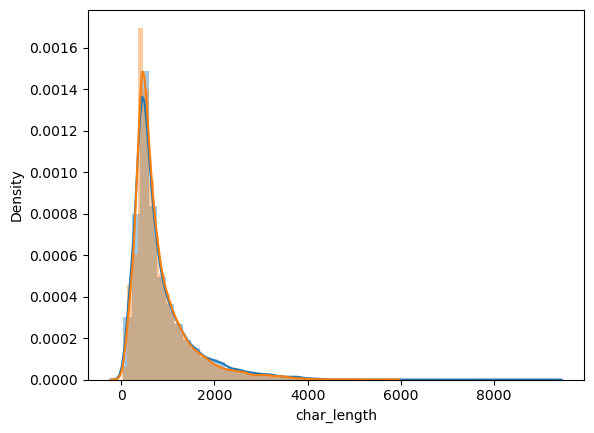

In [29]:
sns.distplot(df[df['sentiment'] == 'positive']['char_length'])
sns.distplot(df[df['sentiment'] == 'negative']['char_length'])

C:\Users\ACER\AppData\Local\Temp\ipykernel_13780\3480675452.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['sentiment'] == 'positive']['word_length'])
C:\Users\ACER\AppData\Local\Temp\ipykernel_13780\3480675452.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['sentiment'] == 

<Axes: xlabel='word_length', ylabel='Density'>

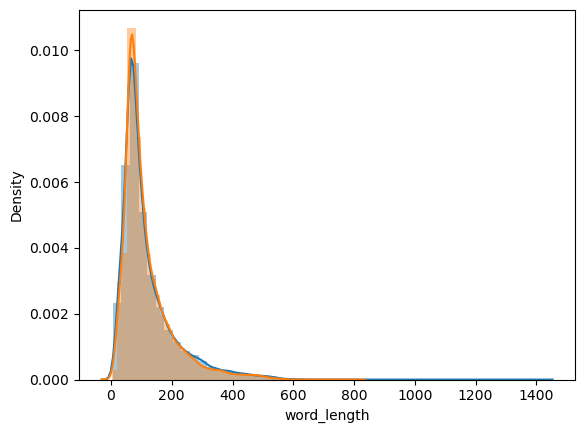

In [30]:
sns.distplot(df[df['sentiment'] == 'positive']['word_length'])
sns.distplot(df[df['sentiment'] == 'negative']['word_length'])

In [31]:
# Making Bigrams


all_tokens = list(chain.from_iterable(df['tokenized_review'])) # Flatten all tokens into one list

# Generate and count bigrams
pd.Series(ngrams(all_tokens, 2)).value_counts() # Flatten all tokens into one list

(ever, seen)          2524
(special, effects)    2109
(even, though)        1850
(one, best)           1818
(looks, like)         1612
                      ... 
(seventies, ie)          1
(ie, serpico)            1
(serpico, stop)          1
(men, fail)              1
(channels, avoid)        1
Name: count, Length: 3309152, dtype: int64

In [32]:
# Making Trigrams


all_tokens = list(chain.from_iterable(df['tokenized_review'])) # Flatten all tokens into one list

# Generate and count trigrams
pd.Series(ngrams(all_tokens, 3)).value_counts() # Flatten all tokens into one list

(movie, ever, seen)         472
(worst, movie, ever)        453
(movies, ever, seen)        348
(one, worst, movies)        298
(worst, movies, ever)       274
                           ... 
(hours, yet, feels)           1
(two, hours, yet)             1
(lasts, almost, two)          1
(type, film, lasts)           1
(channels, avoid, movie)      1
Name: count, Length: 5507221, dtype: int64

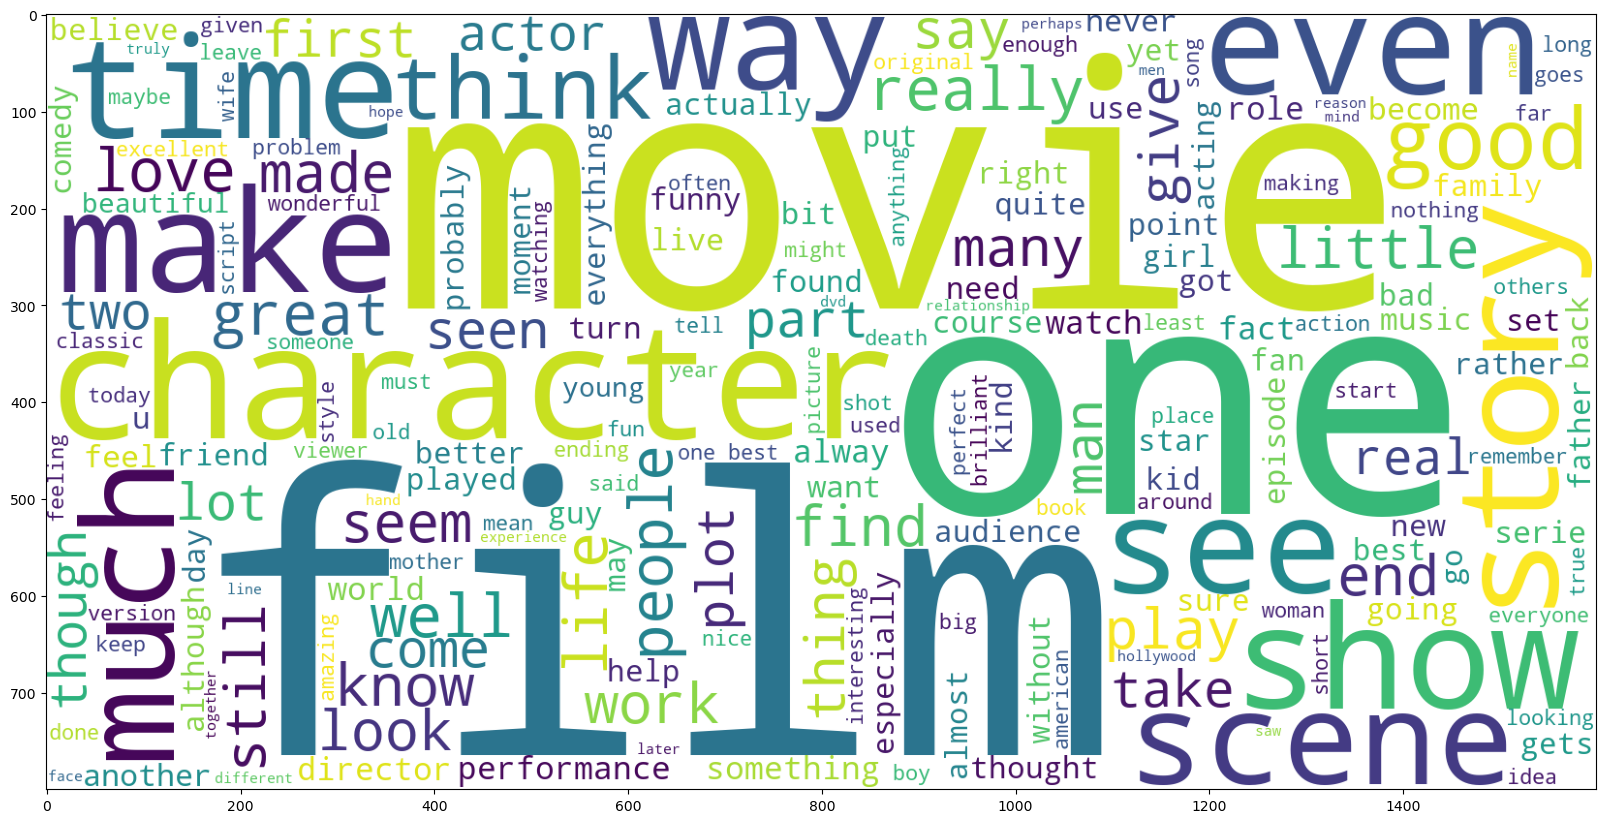

In [36]:
# Word Cloud


plt.figure(figsize = (20,20)) # Positive Review Text
wc = WordCloud(width = 1600 , height = 800, background_color='white').generate(" ".join(df[df['sentiment'] == 'positive']['review']))
plt.imshow(wc)

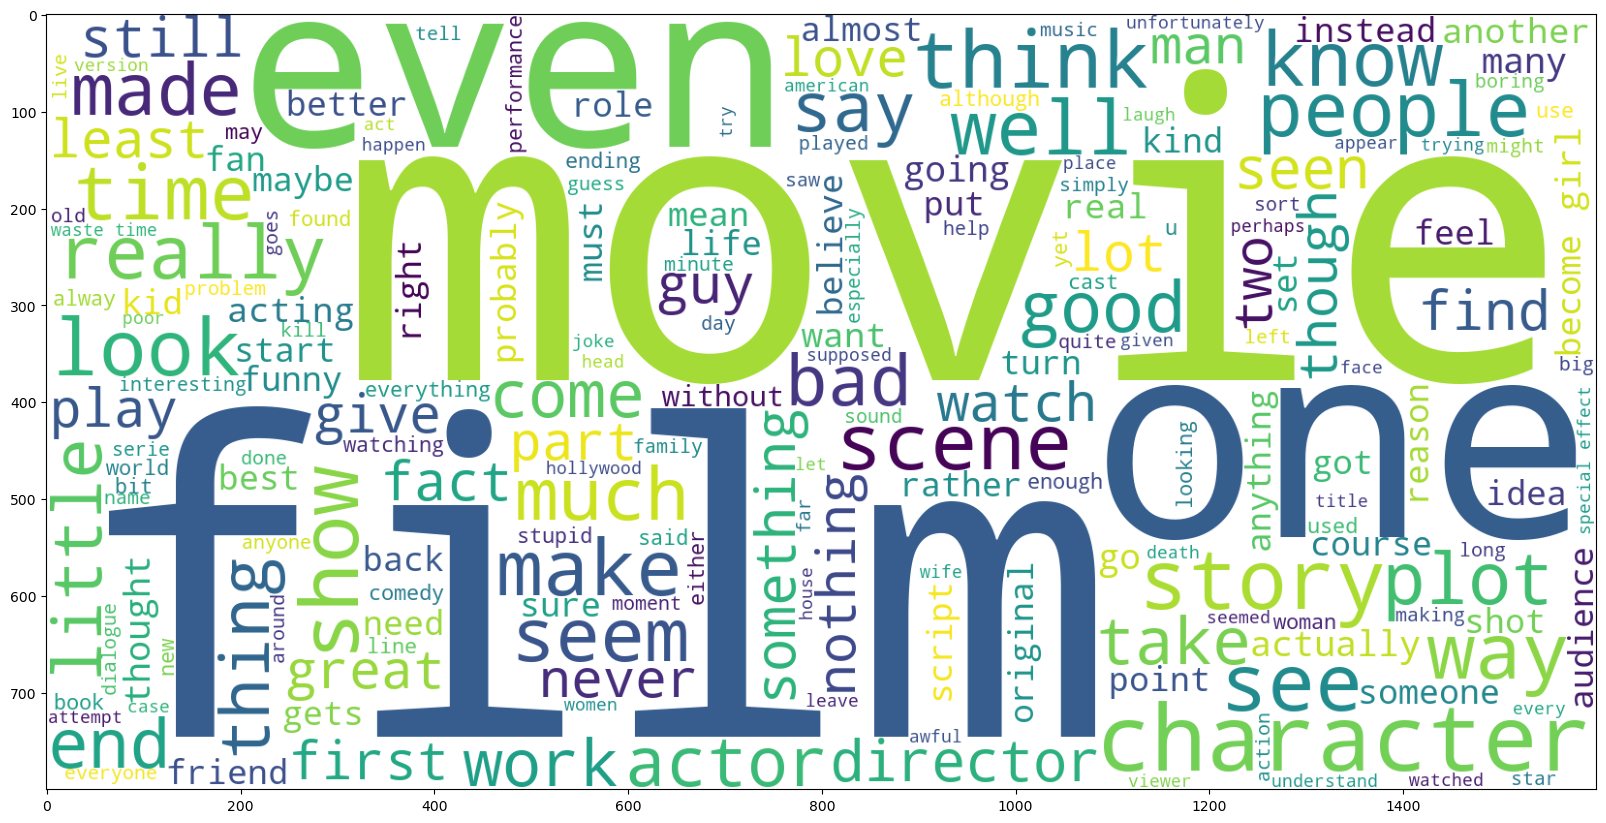

In [37]:
plt.figure(figsize = (20,20)) # Positive Review Text
wc = WordCloud(width = 1600 , height = 800, background_color='white').generate(" ".join(df[df['sentiment'] == 'negative']['review']))
plt.imshow(wc)

### Vectorization

In [41]:
# BoW

count_vectorizer = CountVectorizer(max_features=5000,ngram_range=(1,3))
bag_of_words = count_vectorizer.fit_transform(df['review'])
bag_of_words = pd.DataFrame(bag_of_words.toarray(),columns = count_vectorizer.get_feature_names_out())

In [42]:
bag_of_words

,10,10 10,10 minutes,10 years,100,1010,11,110,12,13,...,young boy,young girl,young man,young woman,younger,youth,zero,zombie,zombies,zone
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49577,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
49578,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
49579,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
49580,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### PCA

In [44]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(bag_of_words.values)

In [45]:
pca_result.shape

(49582, 2)

<Axes: >

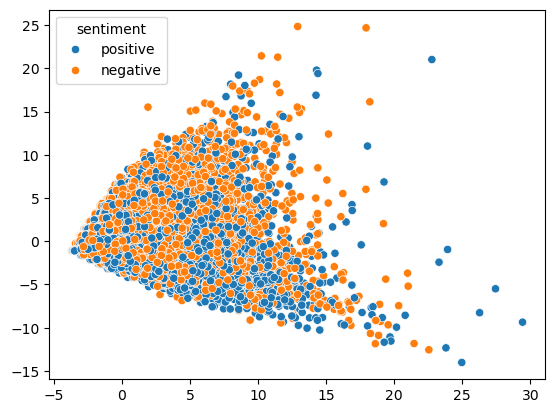

In [47]:
sns.scatterplot(x=pca_result[:,0], y=pca_result[:,1], hue=df['sentiment'])